In [18]:
from collections import defaultdict, deque
import uuid
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [19]:
class MixNode:
    def __init__(self, label, is_leaf=False):
        self.id = str(uuid.uuid4())[:8]
        self.label = label
        self.is_leaf = is_leaf
        self.children = []      # (child_node, cell_count ∈ {1,2,3})
        self.module = None      # (x, y) FPVA coordinate (top-right of 2×2)
        self.timestamp = None

    def add_child(self, child, cells):
        assert cells in {1, 2, 3}
        self.children.append((child, cells))

    def validate(self):
        if not self.is_leaf:
            total = sum(c for _, c in self.children)
            assert total == 4, f"Invalid mixer {self.label}: sum != 4"

In [20]:
def evaluate_ratio(node):
    if node.is_leaf:
        return {node.label: 1}

    result = defaultdict(int)
    for child, cells in node.children:
        sub = evaluate_ratio(child)
        for r, v in sub.items():
            result[r] += cells * v
    return dict(result)

In [21]:
def left_factoring(node):
    if node.is_leaf:
        return

    mixing = [(c, w) for c, w in node.children if not c.is_leaf]
    leaves = [(c, w) for c, w in node.children if c.is_leaf]

    mixing.sort(key=lambda x: -x[1])  # decreasing edge weight
    node.children = mixing + leaves

    for c, _ in node.children:
        left_factoring(c)

In [22]:
def subtree_mix_count(node):
    if node.is_leaf:
        return 0
    return 1 + sum(subtree_mix_count(c) for c, _ in node.children)


def hda_transform(root):
    """
    Paper-faithful HDA:
    - Find most imbalanced child subtree at root
    - Apply ONE ratio-preserving transformation
    - Do NOT recurse
    """

    if root.is_leaf:
        return

    # Step 1: compute subtree loads
    children = root.children
    loads = [(subtree_mix_count(c), i) for i, (c, _) in enumerate(children)]

    max_load, max_i = max(loads)
    min_load, _ = min(loads)

    # Step 2: check imbalance threshold
    if max_load - min_load <= 1:
        return  # already balanced

    heavy_child, heavy_w = children[max_i]

    # Step 3: only expand if heavy child is a reagent
    if heavy_child.is_leaf:
        expanded = MixNode(f"exp({heavy_child.label})")
        for _ in range(4):
            expanded.add_child(
                MixNode(heavy_child.label, is_leaf=True), 1
            )
        children[max_i] = (expanded, heavy_w)

    # Step 4: ONLY permute children, no recursion
    root.children = children

In [23]:
QUADRANTS = [(1,1), (-1,1), (-1,-1), (1,-1)]

def ntm_bind_and_schedule(root):
    occupied = set()
    root.module = (0, 0)
    occupied.add(root.module)

    q = deque([root])

    while q:
        parent = q.popleft()
        if parent.is_leaf:
            continue

        used = set()
        for child, _ in parent.children:
            for qi, (dx, dy) in enumerate(QUADRANTS):
                if qi not in used:
                    cand = (parent.module[0]+dx, parent.module[1]+dy)
                    if cand not in occupied:
                        break
            else:
                dx, dy = QUADRANTS[0]
                r = 1
                while True:
                    cand = (parent.module[0]+dx*r, parent.module[1]+dy*r)
                    if cand not in occupied:
                        break
                    r += 1
            child.module = cand
            occupied.add(cand)
            used.add(qi)
            q.append(child)

    def assign_time(node):
        if node.is_leaf:
            node.timestamp = 0
            return 0
        node.timestamp = 1 + max(assign_time(c) for c, _ in node.children)
        return node.timestamp

    assign_time(root)

In [24]:
def visualize_fpva(root):
    nodes = []

    def collect(n):
        nodes.append(n)
        for c, _ in n.children:
            collect(c)
    collect(root)

    xs = [n.module[0] for n in nodes if n.module]
    ys = [n.module[1] for n in nodes if n.module]

    fig, ax = plt.subplots(figsize=(6,6))
    for n in nodes:
        if n.module:
            x, y = n.module
            rect = patches.Rectangle((x-1, y-1), 2, 2, fill=True, alpha=0.4)
            ax.add_patch(rect)
            ax.text(x, y, n.label, ha='center', va='center', fontsize=9)

    ax.set_xlim(min(xs)-2, max(xs)+2)
    ax.set_ylim(min(ys)-2, max(ys)+2)
    ax.set_aspect('equal')
    ax.set_title("FPVA Module Binding (2×2 Mixers)")
    plt.grid(True)
    plt.show()

In [25]:
def visualize_gantt(root):
    timeline = defaultdict(list)

    def collect(n):
        timeline[n.timestamp].append(n)
        for c, _ in n.children:
            collect(c)
    collect(root)

    fig, ax = plt.subplots(figsize=(8,4))
    y = 0

    for t in sorted(timeline):
        for n in timeline[t]:
            if not n.is_leaf:
                ax.barh(y, 1, left=t, edgecolor='black')
                ax.text(t+0.5, y, n.label, ha='center', va='center')
                y += 1

    ax.set_xlabel("Time Cycles")
    ax.set_ylabel("Mix Operations")
    ax.set_title("Gantt Chart (Parallel Execution)")
    plt.show()


class VisualNode:
    def __init__(self, label, is_leaf):
        self.label = label
        self.is_leaf = is_leaf
        self.children = []  # list of (VisualNode, edge_label)

def expand_for_visualization(node):
    """
    Convert DAG-style mixing tree into a pure tree for drawing.
    Reagents are duplicated per use (paper-style visualization).
    """
    v = VisualNode(node.label, node.is_leaf)
    for child, w in node.children:
        v_child = expand_for_visualization(child)
        v.children.append((v_child, w))
    return v

In [26]:
def compute_layout(root):
    """
    Returns dict: node -> (x, y)
    """
    x_counter = [0]
    pos = {}

    def dfs(node, depth):
        if node.is_leaf:
            x = x_counter[0]
            x_counter[0] += 1
        else:
            xs = []
            for c, _ in node.children:
                xs.append(dfs(c, depth + 1))
            x = sum(xs) / len(xs)
        pos[node] = (x, -depth)
        return x

    dfs(root, 0)
    return pos


def draw_tree(root, title):
    pos = compute_layout(root)

    fig, ax = plt.subplots(figsize=(6, 4))

    # draw edges
    for node in pos:
        for child, w in node.children:
            x1, y1 = pos[node]
            x2, y2 = pos[child]
            ax.plot([x1, x2], [y1, y2], color="black")
            ax.text((x1 + x2)/2, (y1 + y2)/2, str(w),
                    fontsize=8, ha="center", va="center")

    # draw nodes
    for node, (x, y) in pos.items():
        if node.is_leaf:
            rect = patches.Rectangle(
                (x - 0.25, y - 0.15),
                0.5, 0.3,
                facecolor="#f0f0f0",
                edgecolor="black"
            )
            ax.add_patch(rect)
            ax.text(x, y, node.label, ha="center", va="center", fontsize=9)
        else:
            circ = patches.Circle(
                (x, y),
                radius=0.18,
                facecolor="#d9d9d9",
                edgecolor="black"
            )
            ax.add_patch(circ)
            ax.text(x, y, node.label, ha="center", va="center", fontsize=9)

    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()
    plt.show()

In [27]:
R1 = MixNode("R1", is_leaf=True)
R2 = MixNode("R2", is_leaf=True)
R3 = MixNode("R3", is_leaf=True)
R4 = MixNode("R4", is_leaf=True)
R5 = MixNode("R5", is_leaf=True)
R6 = MixNode("R6", is_leaf=True)

# =========================
# Bottom-level mixers
# =========================

# M9 : (2 R1, 2 R2)
M9 = MixNode("M9")
M9.add_child(R1, 2)
M9.add_child(R2, 2)

# M10 : (1 R2, 3 R3)
M10 = MixNode("M10")
M10.add_child(R2, 1)
M10.add_child(R3, 3)

# M11 : (3 R4, 1 R5)
M11 = MixNode("M11")
M11.add_child(R4, 3)
M11.add_child(R5, 1)

# M12 : (2 R5, 2 R6)
M12 = MixNode("M12")
M12.add_child(R5, 2)
M12.add_child(R6, 2)

# =========================
# Mid-level mixers
# =========================

# M5 : (2 R1, 2 R2)
M5 = MixNode("M5")
M5.add_child(R1, 2)
M5.add_child(R2, 2)

# M6 : (1 M9, 1 M10, 1 M11, 1 M12)
M6 = MixNode("M6")
M6.add_child(M9, 1)
M6.add_child(M10, 1)
M6.add_child(M11, 1)
M6.add_child(M12, 1)

# M7 : (1 R2, 3 R3)
M7 = MixNode("M7")
M7.add_child(R2, 1)
M7.add_child(R3, 3)

# M8 : (2 R4, 1 R5, 1 R6)
M8 = MixNode("M8")
M8.add_child(R4, 2)
M8.add_child(R5, 1)
M8.add_child(R6, 1)

# =========================
# Upper-level mixers
# =========================

# M2 : (2 R1, 2 R2)
M2 = MixNode("M2")
M2.add_child(R1, 2)
M2.add_child(R2, 2)

# M3 : (2 R3, 2 R4)
M3 = MixNode("M3")
M3.add_child(R3, 2)
M3.add_child(R4, 2)

# M4 : (1 M5, 1 M6, 1 M7, 1 M8)
M4 = MixNode("M4")
M4.add_child(M5, 1)
M4.add_child(M6, 1)
M4.add_child(M7, 1)
M4.add_child(M8, 1)

# =========================
# Root mixer
# =========================

# M1 : (1 M2, 1 M4, 1 M3, 1 R6)
M1 = MixNode("M1")
M1.add_child(M2, 1)
M1.add_child(M4, 1)
M1.add_child(M3, 1)
M1.add_child(R6, 1)


In [28]:
def validate_tree(node):
    if not node.is_leaf:
        node.validate()
    for c, _ in node.children:
        validate_tree(c)

In [29]:
validate_tree(M1)
print("Final ratio:", evaluate_ratio(M1))

Final ratio: {'R1': 6, 'R2': 8, 'R3': 8, 'R4': 7, 'R5': 4, 'R6': 4}


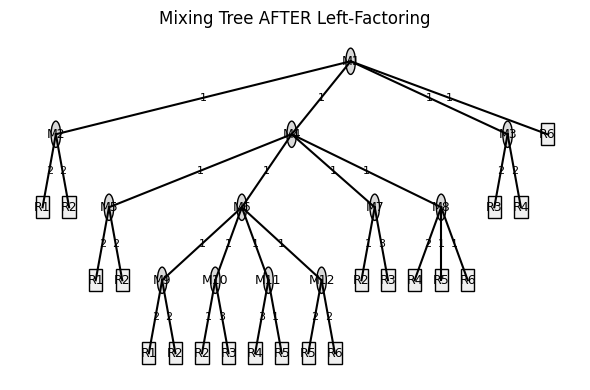

In [30]:
left_factoring(M1)
visual_leftfact = expand_for_visualization(M1)
draw_tree(visual_leftfact, "Mixing Tree AFTER Left-Factoring")

Final ratio after HDA post Left-Factoring: {'R1': 6, 'R2': 8, 'R3': 8, 'R4': 7, 'R5': 4, 'R6': 4}


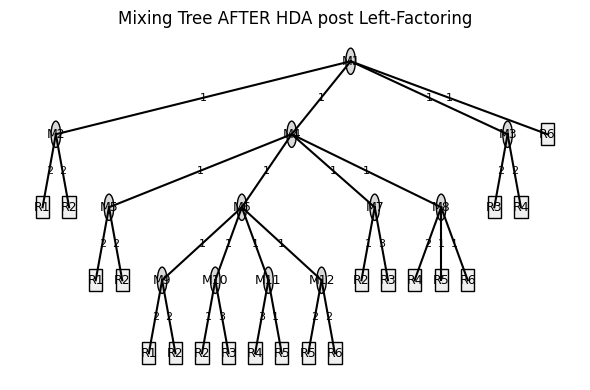

In [31]:
hda_transform(M1)
print("Final ratio after HDA post Left-Factoring:", evaluate_ratio(M1))
visual_after = expand_for_visualization(M1)
draw_tree(visual_after, "Mixing Tree AFTER HDA post Left-Factoring")

In [32]:
ntm_bind_and_schedule(M1)

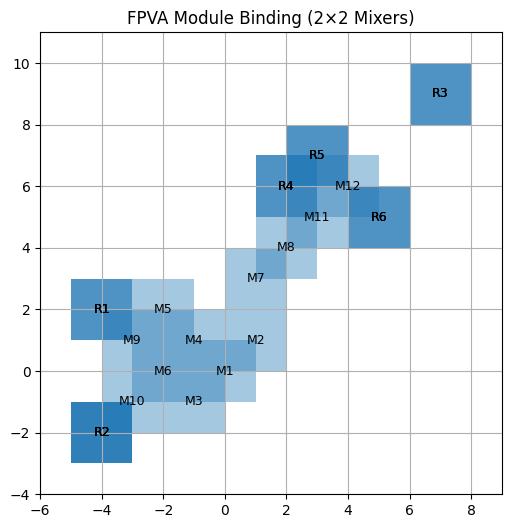

In [33]:
visualize_fpva(M1)

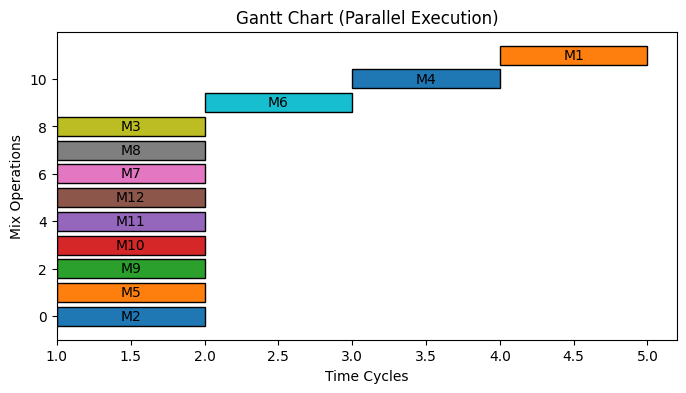

In [34]:
visualize_gantt(M1)